### Imports

In [35]:
import os, glob
import numpy as np
import pandas as pd
from typing import Optional
import matplotlib.pyplot as plt

### Evaluation and Plotting Scripts

In [2]:
def evaluate_selection_strategy(csv_path: str, plot: bool = True):
    """
    Parameters
    ----------
    csv_path : str
        Path to results CSV with columns:
        ['dataset_version','evaluation','split','accuracy','accuracy_std','dataset_distance_to_benchmark']
    plot : bool
        If True, plots a bar chart of average accuracies.

    Returns
    -------
    summary : dict
        {
          'baseline_val_accuracy': float,
          'avg_selection_strategy': float,
          'avg_benchmark_only': float,
          'avg_alt_only': float,
          'num_versions': int,
          'num_selected_benchmark': int,
          'num_selected_alt': int
        }
    per_version : pd.DataFrame
        One row per dataset_version (excluding '__benchmark__'),
        with columns: ['dataset_version','bench_val','bench_test','alt_test','chosen','chosen_test_acc']
    """
    df = pd.read_csv(csv_path)

    # 1) Baseline: benchmark model on __benchmark__ validation
    baseline_rows = df[
        (df["dataset_version"] == "__benchmark__") &
        (df["evaluation"] == "benchmark_model") &
        (df["split"] == "val")
    ]
    if baseline_rows.empty:
        raise ValueError("Baseline row not found: __benchmark__/benchmark_model/val")
    baseline = float(baseline_rows["accuracy"].mean())

    # 2) Build a per-version table (exclude the __benchmark__ row)
    versions = sorted(v for v in df["dataset_version"].unique() if v != "__benchmark__")

    rows = []
    missing = []

    # Counters for requested triggers
    count_bench_ge_baseline = 0  # times benchmark val on new dataset >= baseline val
    count_bench_worse_but_alt_even_worse = 0  # times bench worse than baseline but chosen since alt val < bench val

    for v in versions:
        # benchmark val & test
        bench_val_rows = df[(df["dataset_version"] == v) &
                            (df["evaluation"] == "benchmark_model") &
                            (df["split"] == "val")]
        bench_test_rows = df[(df["dataset_version"] == v) &
                             (df["evaluation"] == "benchmark_model") &
                             (df["split"] == "test")]
        # alt val & test (need alt val for the new decision rule)
        alt_val_rows = df[(df["dataset_version"] == v) &
                          (df["evaluation"] == "alt_model") &
                          (df["split"] == "val")]
        alt_test_rows = df[(df["dataset_version"] == v) &
                           (df["evaluation"] == "alt_model") &
                           (df["split"] == "test")]

        if bench_val_rows.empty or bench_test_rows.empty or alt_test_rows.empty or alt_val_rows.empty:
            missing.append(v)
            continue

        bench_val  = float(bench_val_rows["accuracy"].mean())
        bench_test = float(bench_test_rows["accuracy"].mean())
        alt_val    = float(alt_val_rows["accuracy"].mean())
        alt_test   = float(alt_test_rows["accuracy"].mean())

        # Selection strategy:
        # 1) If benchmark VAL on new dataset >= baseline -> choose benchmark TEST
        # 2) Else (benchmark worse than baseline), compare alt VAL vs benchmark VAL on the new dataset:
        #       - if alt VAL >= bench VAL -> choose alt TEST
        #       - else -> choose benchmark TEST (count this special trigger)
        if bench_val >= baseline:
            chosen = "benchmark_model"
            chosen_acc = bench_test
            count_bench_ge_baseline += 1
        else:
            if alt_val >= bench_val:
                chosen = "alt_model"
                chosen_acc = alt_test
            else:
                chosen = "benchmark_model"
                chosen_acc = bench_test
                count_bench_worse_but_alt_even_worse += 1

        rows.append({
            "dataset_version": v,
            "bench_val": bench_val,
            "bench_test": bench_test,
            "alt_test": alt_test,
            "chosen": chosen,
            "chosen_test_acc": chosen_acc,
        })

    per_version = pd.DataFrame(rows).sort_values("dataset_version").reset_index(drop=True)

    if not per_version.empty:
        avg_selection = float(per_version["chosen_test_acc"].mean())
        avg_bench_only = float(per_version["bench_test"].mean())
        avg_alt_only = float(per_version["alt_test"].mean())
        n_sel_bench = int((per_version["chosen"] == "benchmark_model").sum())
        n_sel_alt = int((per_version["chosen"] == "alt_model").sum())
    else:
        avg_selection = avg_bench_only = avg_alt_only = float("nan")
        n_sel_bench = n_sel_alt = 0

    # 3) Print results
    print(f"Baseline (benchmark __benchmark__ VAL): {baseline:.4f}")
    print(f"Versions included: {len(per_version)}")
    if missing:
        print(f"[WARN] Skipped {len(missing)} versions due to missing rows: {missing[:5]}{' ...' if len(missing)>5 else ''}")
    print(f"Selected benchmark for {n_sel_bench} versions; alt for {n_sel_alt} versions.")
    print(f"Trigger counts:")
    print(f"  • Benchmark ≥ baseline on new VAL (picked benchmark): {count_bench_ge_baseline}")
    print(f"  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): {count_bench_worse_but_alt_even_worse}")
    print(f"\nAverage TEST accuracy (selection strategy): {avg_selection:.4f}")
    print(f"Average TEST accuracy (benchmark-only):     {avg_bench_only:.4f}")
    print(f"Average TEST accuracy (alt-only):           {avg_alt_only:.4f}")

    # 4) Plot
    if plot:
        labels = ["Selection strategy", "Benchmark-only", "Alt-only"]
        values = [avg_selection, avg_bench_only, avg_alt_only]
        plt.figure(figsize=(6,4))
        plt.bar(labels, values)
        plt.ylabel("Average TEST accuracy")
        plt.title("Average Test Accuracy by Strategy")
        for i, v in enumerate(values):
            plt.text(i, v + 0.002, f"{v:.3f}", ha="center", va="bottom")
        plt.tight_layout()
        plt.show()

    summary = {
        "baseline_val_accuracy": baseline,
        "avg_selection_strategy": avg_selection,
        "avg_benchmark_only": avg_bench_only,
        "avg_alt_only": avg_alt_only,
        "num_versions": len(per_version),
        "num_selected_benchmark": n_sel_bench,
        "num_selected_alt": n_sel_alt,
        "num_bench_ge_baseline_val": count_bench_ge_baseline,
        "num_bench_worse_but_alt_even_worse": count_bench_worse_but_alt_even_worse,
    }
    return summary, per_version

In [3]:
def plot_results(
    df: pd.DataFrame,
    *,
    split: str = "test",   # 'val' or 'test'
    title: str = "Performance vs. Distance to Benchmark Dataset",
    legend_benchmark: str = "Benchmark model",
    legend_alt: str = "Alt model",
    save_csv_path: Optional[str] = None,
    show: bool = True,
):
    """
    Plot accuracy (mean over folds if per-fold data is provided) vs dataset distance for a given split.
    Accepts either:
      - per-fold results with columns ['fold','evaluation','split','dataset_distance_to_benchmark','accuracy'], or
      - summary with ['evaluation','split','dataset_distance_to_benchmark','accuracy_mean'].
    """
    import matplotlib.pyplot as plt

    if df is None or df.empty:
        print("No results to plot.")
        return

    # detect per-fold vs summary
    if "fold" in df.columns and "accuracy" in df.columns:
        # average per version/evaluation for the chosen split
        plot_df = (
            df[df["split"] == split]
            .groupby(["dataset_version", "evaluation"], as_index=False)
            .agg(
                accuracy_mean=("accuracy", "mean"),
                dataset_distance_to_benchmark=("dataset_distance_to_benchmark", "first"),
            )
        )
    else:
        plot_df = df[df["split"] == split].rename(columns={"accuracy_mean": "accuracy_mean"})

    df_bench = plot_df[plot_df["evaluation"] == "benchmark_model"]
    df_alt   = plot_df[plot_df["evaluation"] == "alt_model"]

    if df_bench.empty and df_alt.empty:
        print(f"No data to plot for split='{split}'.")
        return

    plt.figure(figsize=(7, 5))
    if not df_bench.empty:
        plt.scatter(
            df_bench["dataset_distance_to_benchmark"], df_bench["accuracy_mean"],
            label=legend_benchmark, marker="o"
        )
    if not df_alt.empty:
        plt.scatter(
            df_alt["dataset_distance_to_benchmark"], df_alt["accuracy_mean"],
            label=legend_alt, marker="^"
        )

    plt.xlabel("Dataset distance to benchmark (0–1)")
    plt.ylabel(f"{split.capitalize()} accuracy (mean over folds)")
    plt.title(title + f" — {split.upper()} split")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

    if save_csv_path:
        df.to_csv(save_csv_path, index=False)
        print(f"Saved results to: {save_csv_path}")

In [49]:
def _process_file(csv_path: str):
    """
    Process one model's CSV and return a per-version DataFrame with:
    ['dataset_version','bench_val','bench_test','alt_val','alt_test',
     'chosen','chosen_test_acc','trig_bench_ge_baseline','trig_bench_worse_but_alt_worse']
    Returns None if baseline is missing or no usable versions.
    """
    df = pd.read_csv(csv_path)

    # Baseline: benchmark model on __benchmark__ validation
    base_rows = df[
        (df["dataset_version"] == "__benchmark__") &
        (df["evaluation"] == "benchmark_model") &
        (df["split"] == "val")
    ]
    if base_rows.empty:
        print(f"[WARN] Baseline missing in {os.path.basename(csv_path)} — skipped.")
        return None
    baseline = float(base_rows["accuracy"].mean())

    versions = sorted(v for v in df["dataset_version"].unique() if v != "__benchmark__")
    rows = []
    for v in versions:
        bench_val_rows = df[(df["dataset_version"] == v) & (df["evaluation"] == "benchmark_model") & (df["split"] == "val")]
        bench_test_rows = df[(df["dataset_version"] == v) & (df["evaluation"] == "benchmark_model") & (df["split"] == "test")]
        alt_val_rows   = df[(df["dataset_version"] == v) & (df["evaluation"] == "alt_model")       & (df["split"] == "val")]
        alt_test_rows  = df[(df["dataset_version"] == v) & (df["evaluation"] == "alt_model")       & (df["split"] == "test")]

        if bench_val_rows.empty or bench_test_rows.empty or alt_val_rows.empty or alt_test_rows.empty:
            continue

        bench_val  = float(bench_val_rows["accuracy"].mean())
        bench_test = float(bench_test_rows["accuracy"].mean())
        alt_val    = float(alt_val_rows["accuracy"].mean())
        alt_test   = float(alt_test_rows["accuracy"].mean())

        # Selection rule:
        # 1) If benchmark VAL on new dataset >= baseline -> choose benchmark TEST
        # 2) Else compare alt VAL vs benchmark VAL:
        #       - if alt VAL >= bench VAL -> choose alt TEST
        #       - else -> choose benchmark TEST
        if bench_val >= baseline:
            chosen = "benchmark_model"
            chosen_acc = bench_test
            trig_bench_ge_baseline = 1
            trig_bench_worse_but_alt_worse = 0
        else:
            trig_bench_ge_baseline = 0
            if alt_val >= bench_val:
                chosen = "alt_model"
                chosen_acc = alt_test
                trig_bench_worse_but_alt_worse = 0
            else:
                chosen = "benchmark_model"
                chosen_acc = bench_test
                trig_bench_worse_but_alt_worse = 1

        rows.append({
            "dataset_version": v,
            "bench_val": bench_val,
            "bench_test": bench_test,
            "alt_val": alt_val,
            "alt_test": alt_test,
            "chosen": chosen,
            "chosen_test_acc": chosen_acc,
            "trig_bench_ge_baseline": trig_bench_ge_baseline,
            "trig_bench_worse_but_alt_worse": trig_bench_worse_but_alt_worse,
        })

    if not rows:
        return None
    return pd.DataFrame(rows)

def print_aggregated_selection_summary(results_dir="results", datasets=("tep","fcc")):
    for ds in datasets:
        files = sorted(glob.glob(os.path.join(results_dir, f"{ds}_results_*.csv")))
        if not files:
            print(f"[{ds.upper()}] No result files found.")
            continue

        all_rows = []
        for fp in files:
            per_version = _process_file(fp)
            if per_version is not None and not per_version.empty:
                per_version["__model__"] = os.path.splitext(os.path.basename(fp))[0]
                all_rows.append(per_version)

        if not all_rows:
            print(f"[{ds.upper()}] No usable versions across models.")
            continue

        agg = pd.concat(all_rows, ignore_index=True)

        avg_selection  = float(agg["chosen_test_acc"].mean())
        avg_bench_only = float(agg["bench_test"].mean())
        avg_alt_only   = float(agg["alt_test"].mean())

        n_sel_bench = int((agg["chosen"] == "benchmark_model").sum())
        n_sel_alt   = int((agg["chosen"] == "alt_model").sum())

        trig_ge_base = int(agg["trig_bench_ge_baseline"].sum())
        trig_bench_worse_alt_worse = int(agg["trig_bench_worse_but_alt_worse"].sum())

        # ---- concise per-dataset printout ----
        print(f"[{ds.upper()}] Average TEST accuracy (selection strategy): {avg_selection:.4f}")
        print(f"[{ds.upper()}] Average TEST accuracy (benchmark-only):     {avg_bench_only:.4f}")
        print(f"[{ds.upper()}] Average TEST accuracy (alt-only):           {avg_alt_only:.4f}")
        print(f"[{ds.upper()}] Selected benchmark for {n_sel_bench} versions; alt for {n_sel_alt} versions.")
        print(f"[{ds.upper()}] Trigger counts:")
        print(f"[{ds.upper()}]   • Benchmark ≥ baseline on new VAL (picked benchmark): {trig_ge_base}")
        print(f"[{ds.upper()}]   • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): {trig_bench_worse_alt_worse}")
        print()

In [ ]:
# ---------- helpers ----------
def _load_results(results_dir: str, dataset: str, split: str = "test") -> pd.DataFrame:
    """Unify CSVs to columns: ['evaluation','distance','accuracy'] pooled over all classifiers."""
    files = sorted(glob.glob(os.path.join(results_dir, f"{dataset}_results_*.csv")))
    frames = []
    for fp in files:
        try:
            df = pd.read_csv(fp)
            df = df[df["split"] == split].copy()
            # unify per-fold vs. summary
            if "fold" in df.columns and "accuracy" in df.columns:
                df = (df.groupby(["dataset_version","evaluation"], as_index=False)
                        .agg(accuracy=("accuracy","mean"),
                             dataset_distance_to_benchmark=("dataset_distance_to_benchmark","first")))
            else:
                if "accuracy_mean" in df.columns:
                    df = df.rename(columns={"accuracy_mean":"accuracy"})
                df = df[["dataset_version","evaluation","dataset_distance_to_benchmark","accuracy"]].copy()
            df = df.rename(columns={"dataset_distance_to_benchmark":"distance"})
            frames.append(df[["evaluation","distance","accuracy"]])
        except Exception as e:
            print(f"[WARN] Skipping {fp}: {e}")
    if not frames:
        return pd.DataFrame(columns=["evaluation","distance","accuracy"])
    out = pd.concat(frames, ignore_index=True)
    return out.dropna(subset=["evaluation","distance","accuracy"])

def _pearson_ci(x, y):
    """Pearson r with ~95% CI via Fisher z (returns r, lo, hi, n)."""
    x = np.asarray(x); y = np.asarray(y)
    m = (~np.isnan(x)) & (~np.isnan(y))
    x = x[m]; y = y[m]
    n = len(x)
    if n < 4:
        return np.nan, np.nan, np.nan, n
    r = np.corrcoef(x, y)[0, 1]
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1.0 / np.sqrt(n - 3)
    zcrit = 1.96  # ~95%
    lo = np.tanh(z - zcrit * se)
    hi = np.tanh(z + zcrit * se)
    return float(r), float(lo), float(hi), int(n)

def _spearman(x, y):
    """Spearman ρ via Pearson on ranks."""
    xr = pd.Series(x).rank().to_numpy()
    yr = pd.Series(y).rank().to_numpy()
    if len(xr) < 2:
        return np.nan
    return float(np.corrcoef(xr, yr)[0, 1])

def _ols_slope(x, y):
    """OLS slope of y ~ a + b*x (returns b, a)."""
    x = np.asarray(x); y = np.asarray(y)
    m = (~np.isnan(x)) & (~np.isnan(y))
    x = x[m]; y = y[m]
    if len(x) < 2:
        return np.nan, np.nan
    b, a = np.polyfit(x, y, 1)
    return float(b), float(a)

def print_cor_stats(results_dir="results", datasets=("tep","fcc"), split="test"):
    label_map = {"benchmark_model": "Benchmark", "alt_model": "Retrained"}
    for ds in datasets:
        df = _load_results(results_dir, ds, split=split)
        if df.empty:
            print(f"[{ds.upper()}] No data found.")
            continue
        for ev in ("benchmark_model", "alt_model"):
            g = df[df["evaluation"] == ev]
            x = g["distance"].to_numpy()
            y = g["accuracy"].to_numpy()
            r, lo, hi, n = _pearson_ci(x, y)
            rho = _spearman(x, y)
            slope, _ = _ols_slope(x, y)
            name = label_map.get(ev, ev)
            # format: 3 decimals, match your example style
            if n < 1:
                print(f"[{ds.upper()}] {name}: n=0 | Pearson r=nan (95% CI nan..nan) | Spearman ρ=nan | OLS slope dAcc/dDist=nan")
            else:
                print(f"[{ds.upper()}] {name}: n={n} | Pearson r={r:.3f} (95% CI {lo:.3f}..{hi:.3f}) | Spearman ρ={rho:.3f} | OLS slope dAcc/dDist={slope:.3f}")


In [51]:
def _load_results(results_dir, dataset, split="test"):
    files = sorted(glob.glob(os.path.join(results_dir, f"{dataset}_results_*.csv")))
    frames = []
    for fp in files:
        try:
            df = pd.read_csv(fp)
            df = df[df["split"] == split].copy()
            # unify schema -> ['dataset_version','evaluation','distance','accuracy']
            if "fold" in df.columns and "accuracy" in df.columns:
                df = (df.groupby(["dataset_version","evaluation"], as_index=False)
                        .agg(accuracy=("accuracy","mean"),
                             dataset_distance_to_benchmark=("dataset_distance_to_benchmark","first")))
            else:
                if "accuracy_mean" in df.columns:
                    df = df.rename(columns={"accuracy_mean":"accuracy"})
                df = df[["dataset_version","evaluation","dataset_distance_to_benchmark","accuracy"]].copy()
            df = df.rename(columns={"dataset_distance_to_benchmark":"distance"})
            frames.append(df)
        except Exception as e:
            print(f"[WARN] {fp}: {e}")
    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, ignore_index=True)
    out = out.dropna(subset=["distance","accuracy","evaluation"])
    return out

def _shared_binning(df, nbins=10, strategy="quantile"):
    """Assign a shared bin_id and bin center to all rows so both evaluations align."""
    x = df["distance"].to_numpy()
    if strategy == "quantile":
        edges = np.unique(np.quantile(x, np.linspace(0, 1, nbins+1)))
        if len(edges) <= 2:
            edges = np.linspace(x.min(), x.max(), nbins+1)
    else:
        edges = np.linspace(x.min(), x.max(), nbins+1)
    df = df.copy()
    df["bin_id"] = pd.cut(df["distance"], bins=edges, labels=False, include_lowest=True, right=True)
    centers = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    centers = pd.Series(centers, name="center")
    return df, centers

def _bin_stats_shared(df, nbins=10):
    """Compute mean and 95% CI per (bin_id, evaluation) using shared bins; return trend only."""
    df, centers = _shared_binning(df, nbins=nbins, strategy="quantile")
    df = df.dropna(subset=["bin_id"])
    df["bin_id"] = df["bin_id"].astype(int)

    g = df.groupby(["bin_id","evaluation"])["accuracy"]
    stats = g.agg(["mean","count","std"]).reset_index()
    stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))
    stats["ci"]  = 1.96 * stats["sem"]
    stats["lo"]  = stats["mean"] - stats["ci"]
    stats["hi"]  = stats["mean"] + stats["ci"]
    stats = stats.merge(centers.rename_axis("bin_id").reset_index(), on="bin_id", how="left")

    trend = stats.pivot(index="center", columns="evaluation", values=["mean","lo","hi"])
    for key in [("mean","benchmark_model"),("lo","benchmark_model"),("hi","benchmark_model"),
                ("mean","alt_model"),("lo","alt_model"),("hi","alt_model")]:
        if key not in trend.columns:
            trend[key] = np.nan
    trend = trend.sort_index().reset_index()
    return trend

def plot_compact(results_dir="results", datasets=("tep","fcc"), split="test", nbins=10, figsize=(11,4), y_lim=(0,1)):
    fig, axes = plt.subplots(1, len(datasets), figsize=figsize, sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    for col, dataset in enumerate(datasets):
        df = _load_results(results_dir, dataset, split=split)
        ax = axes[col]
        if df.empty:
            ax.set_visible(False)
            continue

        trend = _bin_stats_shared(df, nbins=nbins)
        ax.plot(trend["center"], trend[("mean","benchmark_model")], linestyle="--", linewidth=2, label="Benchmark")
        ax.fill_between(trend["center"], trend[("lo","benchmark_model")], trend[("hi","benchmark_model")], alpha=0.18)
        ax.plot(trend["center"], trend[("mean","alt_model")], linestyle="-", linewidth=2, label="Retrained")
        ax.fill_between(trend["center"], trend[("lo","alt_model")], trend[("hi","alt_model")], alpha=0.18)

        ax.set_ylim(y_lim)
        ax.grid(True, alpha=0.3)
        ax.set_title(f"{dataset.upper()} — {split.upper()}")
        ax.set_xlabel("Dataset distance to benchmark")
        if col == 0:
            ax.set_ylabel("Test accuracy")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    fig.tight_layout()

    try:
        fname = f"compact_plot_{'_'.join(datasets)}_{split}.svg"
        save_path = os.path.join(results_dir, fname)
        fig.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Saved plot to: {save_path}")
    except Exception as e:
        print(f"[WARN] Could not save SVG: {e}")

    plt.show()

In [69]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _load_results(results_dir, dataset, split="test"):
    files = sorted(glob.glob(os.path.join(results_dir, f"{dataset}_results_*.csv")))
    frames = []
    for fp in files:
        try:
            df = pd.read_csv(fp)
            df = df[df["split"] == split].copy()
            # unify schema -> ['dataset_version','evaluation','distance','accuracy']
            if "fold" in df.columns and "accuracy" in df.columns:
                df = (
                    df.groupby(["dataset_version", "evaluation"], as_index=False)
                      .agg(accuracy=("accuracy", "mean"),
                           dataset_distance_to_benchmark=("dataset_distance_to_benchmark", "first"))
                )
            else:
                if "accuracy_mean" in df.columns:
                    df = df.rename(columns={"accuracy_mean": "accuracy"})
                df = df[
                    ["dataset_version", "evaluation", "dataset_distance_to_benchmark", "accuracy"]
                ].copy()
            df = df.rename(columns={"dataset_distance_to_benchmark": "distance"})
            frames.append(df)
        except Exception as e:
            print(f"[WARN] {fp}: {e}")
    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, ignore_index=True)
    out = out.dropna(subset=["distance", "accuracy", "evaluation"])
    return out

def _shared_binning(df, nbins=10, strategy="quantile"):
    """Assign a shared bin_id and bin center to all rows so both evaluations align."""
    x = df["distance"].to_numpy()
    if strategy == "quantile":
        edges = np.unique(np.quantile(x, np.linspace(0, 1, nbins + 1)))
        if len(edges) <= 2:
            edges = np.linspace(x.min(), x.max(), nbins + 1)
    else:
        edges = np.linspace(x.min(), x.max(), nbins + 1)
    df = df.copy()
    df["bin_id"] = pd.cut(
        df["distance"], bins=edges, labels=False, include_lowest=True, right=True
    )
    centers = [(edges[i] + edges[i + 1]) / 2.0 for i in range(len(edges) - 1)]
    centers = pd.Series(centers, name="center")
    return df, centers

def _bin_stats_shared(df, nbins=10):
    """Compute mean and 95% CI per (bin_id, evaluation) using shared bins; return trend only."""
    df, centers = _shared_binning(df, nbins=nbins, strategy="quantile")
    df = df.dropna(subset=["bin_id"])
    df["bin_id"] = df["bin_id"].astype(int)

    g = df.groupby(["bin_id", "evaluation"])["accuracy"]
    stats = g.agg(["mean", "count", "std"]).reset_index()
    stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))
    stats["ci"] = 1.96 * stats["sem"]
    stats["lo"] = stats["mean"] - stats["ci"]
    stats["hi"] = stats["mean"] + stats["ci"]
    stats = stats.merge(
        centers.rename_axis("bin_id").reset_index(), on="bin_id", how="left"
    )

    trend = stats.pivot(index="center", columns="evaluation", values=["mean", "lo", "hi"])
    for key in [
        ("mean", "benchmark_model"),
        ("lo", "benchmark_model"),
        ("hi", "benchmark_model"),
        ("mean", "alt_model"),
        ("lo", "alt_model"),
        ("hi", "alt_model"),
    ]:
        if key not in trend.columns:
            trend[key] = np.nan
    trend = trend.sort_index().reset_index()
    return trend

def plot_compact(
    results_dir="results",
    datasets=("tep", "fcc"),
    split="test",
    nbins=10,
    figsize=(7, 8),
    y_lim=(0, 1),
):
    """
    Vertical layout (TEP first). No titles. Legend is placed inside the top subplot.
    Subfigure labels '(a)', '(b)' are placed below each subplot.
    Independent x-axes for each subplot; each subplot has its own x- and y-labels.
    """
    # Enforce TEP first
    order = {"tep": 0, "fcc": 1}
    datasets = tuple(sorted(datasets, key=lambda d: order.get(d, 99)))

    # Independent x-axes (sharex=False), same y-scale (sharey=True)
    fig, axes = plt.subplots(len(datasets), 1, figsize=figsize, sharex=False, sharey=True)
    if len(datasets) == 1:
        axes = [axes]

    for row, dataset in enumerate(datasets):
        df = _load_results(results_dir, dataset, split=split)
        ax = axes[row]
        if df.empty:
            ax.set_visible(False)
            continue

        trend = _bin_stats_shared(df, nbins=nbins)

        # Curves + CI (no titles)
        ax.plot(
            trend["center"],
            trend[("mean", "benchmark_model")],
            linestyle="--",
            linewidth=2,
            label="Static-baseline",
        )
        ax.fill_between(
            trend["center"],
            trend[("lo", "benchmark_model")],
            trend[("hi", "benchmark_model")],
            alpha=0.18,
        )
        ax.plot(
            trend["center"],
            trend[("mean", "alt_model")],
            linestyle="-",
            linewidth=2,
            label="Retraining-baseline",
        )
        ax.fill_between(
            trend["center"],
            trend[("lo", "alt_model")],
            trend[("hi", "alt_model")],
            alpha=0.18,
        )

        ax.set_ylim(y_lim)
        ax.grid(True, alpha=0.3)

        # Axis labels on BOTH subplots
        ax.set_ylabel("Test accuracy")
        ax.set_xlabel("Dataset distance to benchmark")

        # Legend INSIDE the top subplot only
        if row == 0:
            ax.legend(loc="lower left", frameon=True)

        # Subfigure label (a), (b) BELOW each axis
        ax.text(0.5, -0.25, f"({chr(ord('a') + row)})", transform=ax.transAxes,
            ha="center", va="top", fontsize=11)

    # More vertical spacing between subplots & room for labels below
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.35, bottom=0.05)

    # Save SVG
    try:
        fname = f"compact_plot_{'_'.join(datasets)}_{split}.pdf"
        save_path = os.path.join(results_dir, fname)
        fig.savefig(save_path, format="pdf", bbox_inches="tight")
        print(f"Saved plot to: {save_path}")
    except Exception as e:
        print(f"[WARN] Could not save PDF: {e}")

    plt.show()

### Parametrization

In [4]:
# classifiers
from classifiers.WDI_1NN import WDI_1NN
from classifiers.ACM_SVM import ACM_SVM
from classifiers.CASIM import CASIM
from classifiers.EAC_1NN import EAC_1NN
from classifiers.MBW_LR import MBW_LR

# ---------------- Params 
wdi_1nn_params = {"template_threshold": 0.5}
acm_svm_params = None
casim_params = {
    "num_features": 672,
    "n_estimators": 1,
    "n_jobs_multirocket": 1,
    "random_state": 42,
    "alphas": np.logspace(-3, 3, 10),
}
eac_1nn_params = {"attenuation_coefficient_per_min": 0.001}  # 0.0667}
mbw_lr_params = {
    "penalty": None,
    "fit_intercept": False,
    "solver": "lbfgs",
    "multi_class": "ovr",
    "decision_bounds": True,
    "confidence_interval": 1.96,
}

# list of models and model_params to evaluate
models_to_evaluate = [
    (WDI_1NN, wdi_1nn_params, "WDI-1NN", True),
    (CASIM, casim_params, "CASIM", False),
    (EAC_1NN, eac_1nn_params, "EAC-1NN", True),
    (MBW_LR, mbw_lr_params, "MBW-LR", False),
    (ACM_SVM, acm_svm_params, "ACM-SVM", False),
]

### Experiments

In [43]:
print_cor_stats(results_dir="results", datasets=(["tep", "fcc"]), split="test")

[TEP] Benchmark: n=1005 | Pearson r=-0.643 (95% CI -0.678..-0.605) | Spearman ρ=-0.611 | OLS slope dAcc/dDist=-14.351
[TEP] Retrained: n=1000 | Pearson r=-0.042 (95% CI -0.104..0.020) | Spearman ρ=0.001 | OLS slope dAcc/dDist=-0.511
[FCC] Benchmark: n=1005 | Pearson r=-0.608 (95% CI -0.646..-0.568) | Spearman ρ=-0.596 | OLS slope dAcc/dDist=-5.158
[FCC] Retrained: n=1000 | Pearson r=0.033 (95% CI -0.029..0.095) | Spearman ρ=-0.002 | OLS slope dAcc/dDist=0.116


Saved plot to: results\compact_plot_tep_fcc_test.pdf


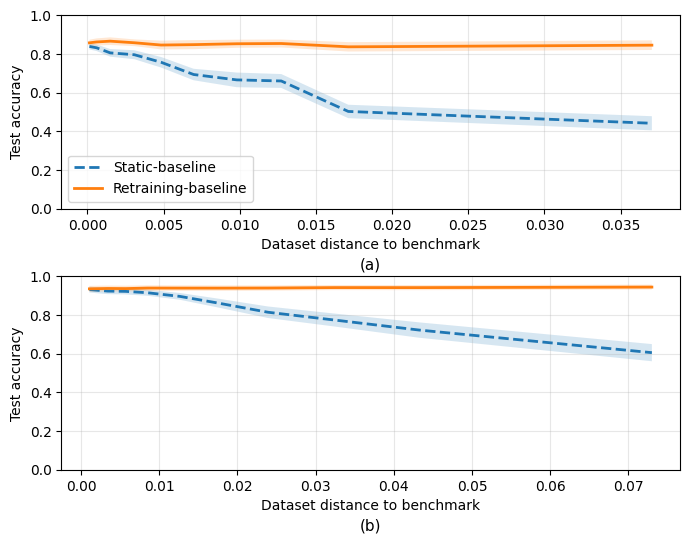

In [70]:
plot_compact(results_dir="results", datasets=(["tep", "fcc"]), split="test", nbins=10, y_lim=(0,1), figsize=(7,5))

Saved plot to: results\compact_plot_tep_fcc_test.svg


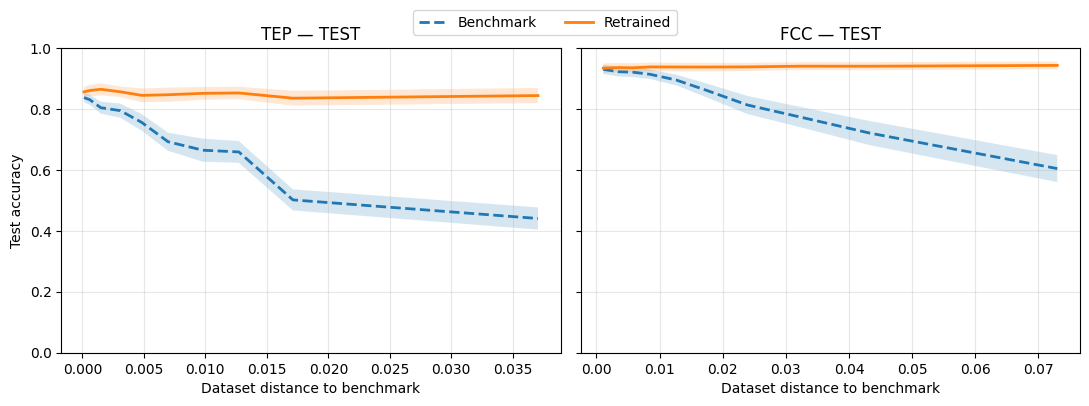

In [52]:
plot_compact(results_dir="results", datasets=(["tep", "fcc"]), split="test", nbins=10, y_lim=(0,1))

In [50]:
print_aggregated_selection_summary(results_dir="results", datasets=("tep","fcc"))

[TEP] Average TEST accuracy (selection strategy): 0.8514
[TEP] Average TEST accuracy (benchmark-only):     0.6987
[TEP] Average TEST accuracy (alt-only):           0.8520
[TEP] Selected benchmark for 313 versions; alt for 687 versions.
[TEP] Trigger counts:
[TEP]   • Benchmark ≥ baseline on new VAL (picked benchmark): 263
[TEP]   • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 50

[FCC] Average TEST accuracy (selection strategy): 0.9372
[FCC] Average TEST accuracy (benchmark-only):     0.8363
[FCC] Average TEST accuracy (alt-only):           0.9390
[FCC] Selected benchmark for 168 versions; alt for 832 versions.
[FCC] Trigger counts:
[FCC]   • Benchmark ≥ baseline on new VAL (picked benchmark): 154
[FCC]   • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 14



#### FCC


[INFO] Loading and plotting: results/fcc_results_wdi_1nn.csv


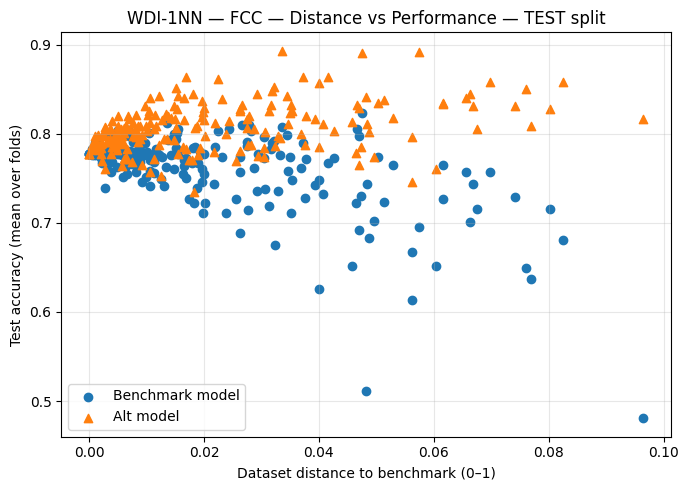


[INFO] Loading and plotting: results/fcc_results_casim.csv


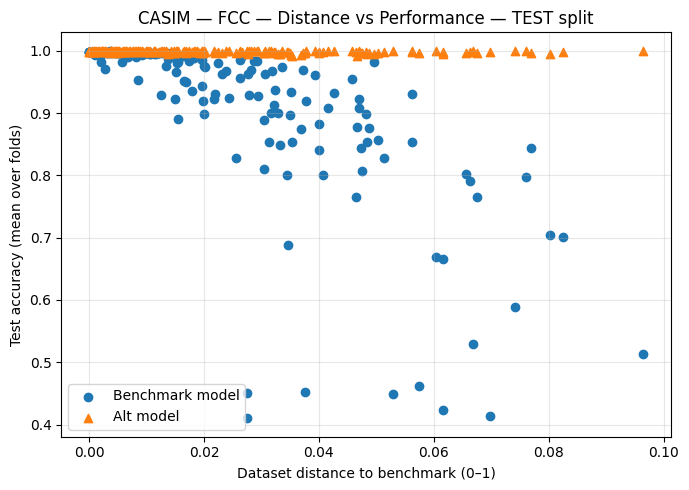


[INFO] Loading and plotting: results/fcc_results_eac_1nn.csv


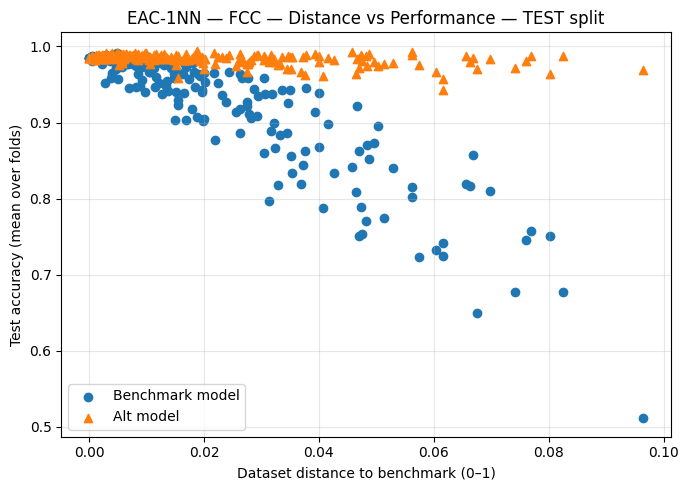


[INFO] Loading and plotting: results/fcc_results_mbw_lr.csv


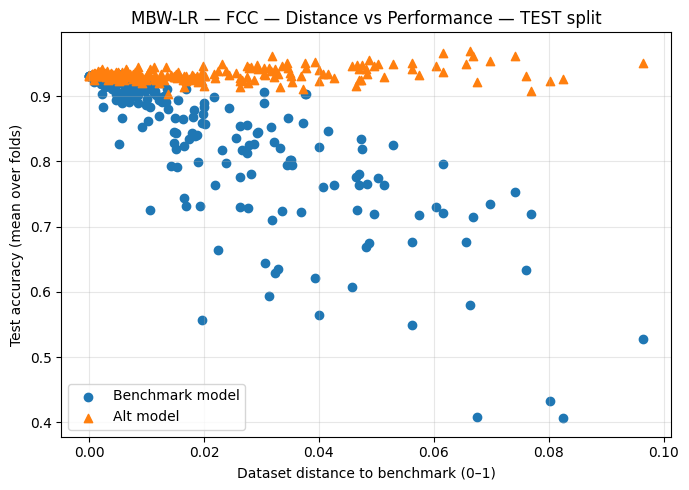


[INFO] Loading and plotting: results/fcc_results_acm_svm.csv


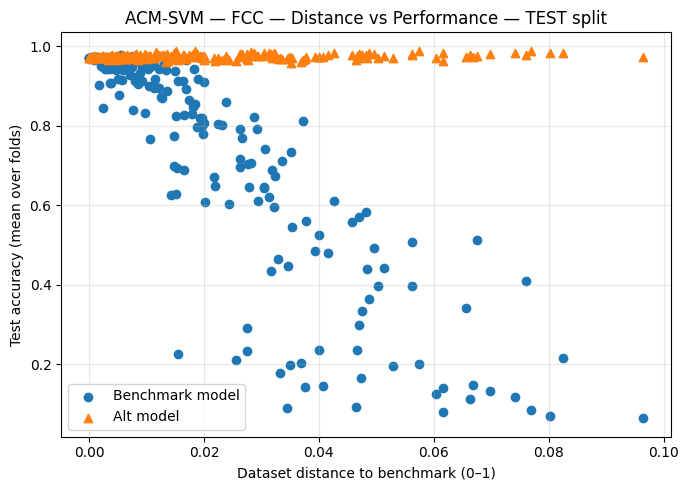

In [5]:
datasets = ["fcc"]
splits = ["test"]

for dataset in datasets:
    for _, _, model_name, _ in models_to_evaluate:
        csv_path = f"results/{dataset}_results_{model_name.lower().replace('-', '_')}.csv"
        if not os.path.isfile(csv_path):
            print(f"[WARN] Results CSV not found: {csv_path}. Skipping.")
            continue
        print(f"\n[INFO] Loading and plotting: {csv_path}")
        df = pd.read_csv(csv_path)
        for split in splits:
            try:
                plot_results(
                    df,
                    split=split,
                    title=f"{model_name} — {dataset.upper()} — Distance vs Performance",
                    show=True
                )
            except Exception as e:
                print(f"[ERROR] Failed to plot {csv_path} (split={split}): {e}")


=== Evaluating selection strategy for model: WDI-1NN ===
Baseline (benchmark __benchmark__ VAL): 0.7836
Versions included: 200
Selected benchmark for 78 versions; alt for 122 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 70
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 8

Average TEST accuracy (selection strategy): 0.7974
Average TEST accuracy (benchmark-only):     0.7596
Average TEST accuracy (alt-only):           0.8058


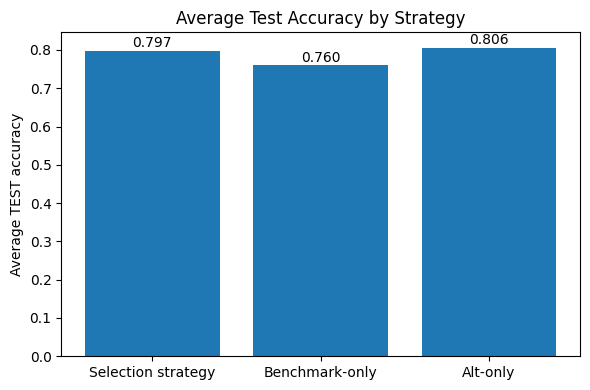


=== Evaluating selection strategy for model: CASIM ===
Baseline (benchmark __benchmark__ VAL): 0.9977
Versions included: 200
Selected benchmark for 29 versions; alt for 171 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 29
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 0

Average TEST accuracy (selection strategy): 0.9979
Average TEST accuracy (benchmark-only):     0.9281
Average TEST accuracy (alt-only):           0.9981


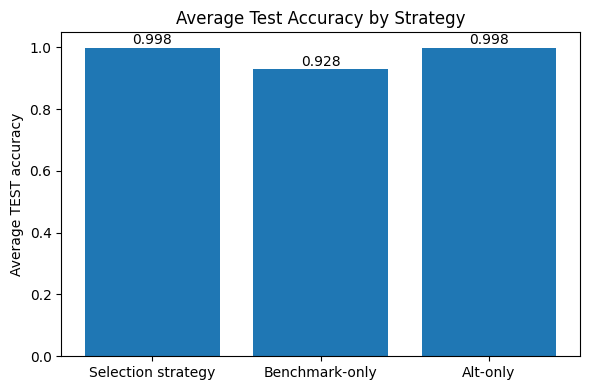


=== Evaluating selection strategy for model: EAC-1NN ===
Baseline (benchmark __benchmark__ VAL): 0.9844
Versions included: 200
Selected benchmark for 29 versions; alt for 171 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 28
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 1

Average TEST accuracy (selection strategy): 0.9834
Average TEST accuracy (benchmark-only):     0.9252
Average TEST accuracy (alt-only):           0.9835


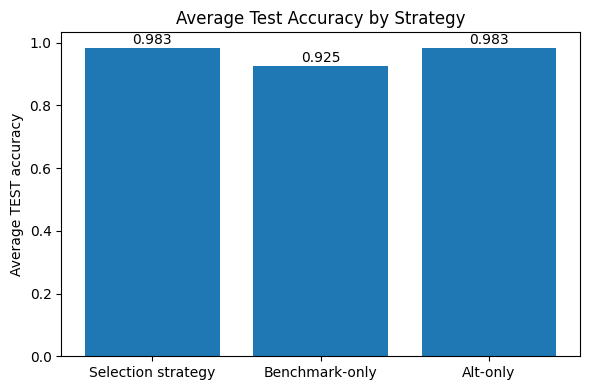


=== Evaluating selection strategy for model: MBW-LR ===
Baseline (benchmark __benchmark__ VAL): 0.9406
Versions included: 200
Selected benchmark for 18 versions; alt for 182 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 13
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 5

Average TEST accuracy (selection strategy): 0.9333
Average TEST accuracy (benchmark-only):     0.8365
Average TEST accuracy (alt-only):           0.9336


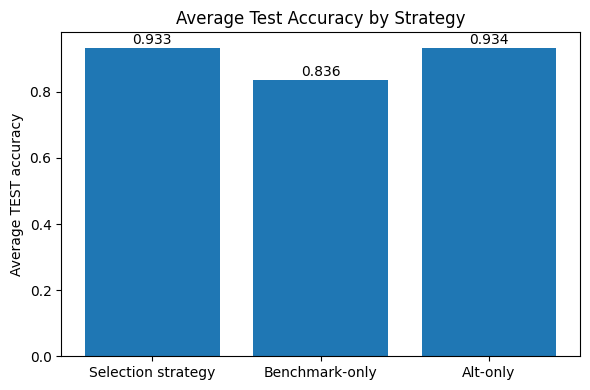


=== Evaluating selection strategy for model: ACM-SVM ===
Baseline (benchmark __benchmark__ VAL): 0.9766
Versions included: 200
Selected benchmark for 14 versions; alt for 186 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 14
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 0

Average TEST accuracy (selection strategy): 0.9738
Average TEST accuracy (benchmark-only):     0.7319
Average TEST accuracy (alt-only):           0.9738


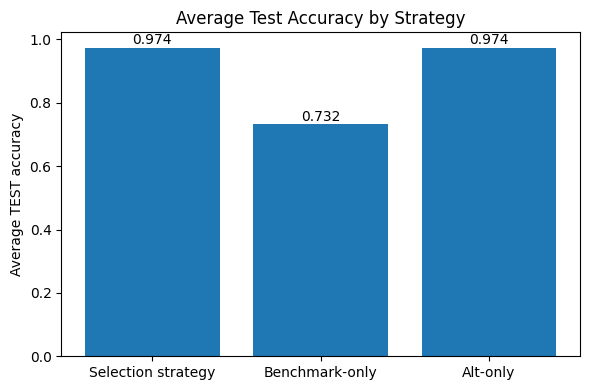

In [6]:
for model, model_params, model_name, use_argmin in models_to_evaluate:
    print(f"\n=== Evaluating selection strategy for model: {model_name} ===")
    csv_path = f"results/fcc_results_{model_name.lower().replace('-', '_')}.csv"
    if not os.path.isfile(csv_path):
        print(f"[WARN] Results CSV not found: {csv_path}. Skipping.")
        continue
    summary, per_version = evaluate_selection_strategy(csv_path, plot=True)

#### FCC Evaluation


[INFO] Loading and plotting: results/tep_results_wdi_1nn.csv


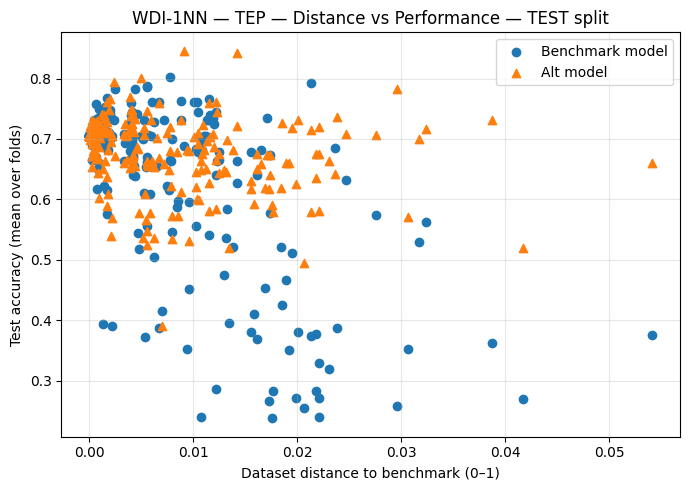


[INFO] Loading and plotting: results/tep_results_casim.csv


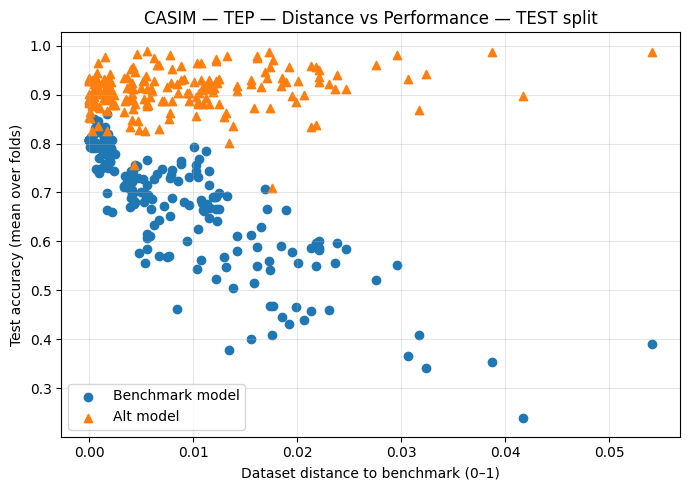


[INFO] Loading and plotting: results/tep_results_eac_1nn.csv


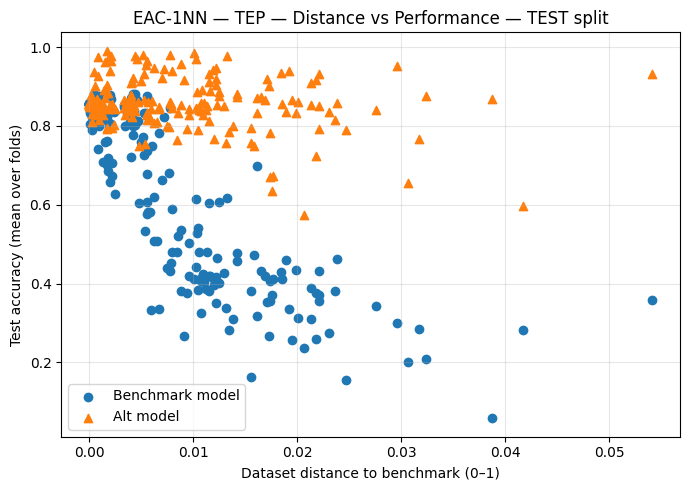


[INFO] Loading and plotting: results/tep_results_mbw_lr.csv


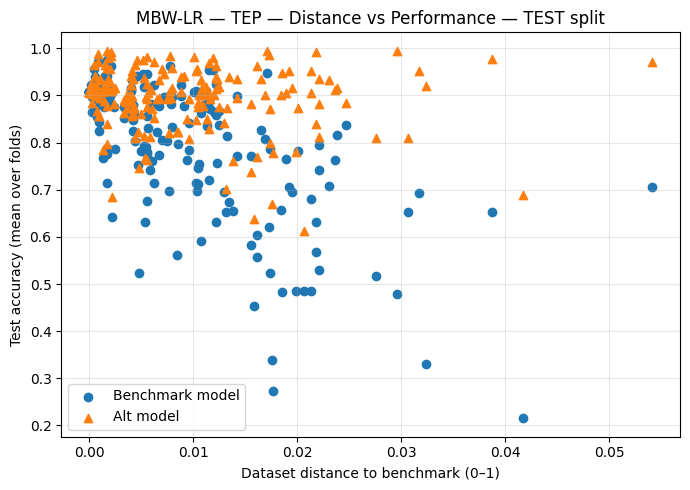


[INFO] Loading and plotting: results/tep_results_acm_svm.csv


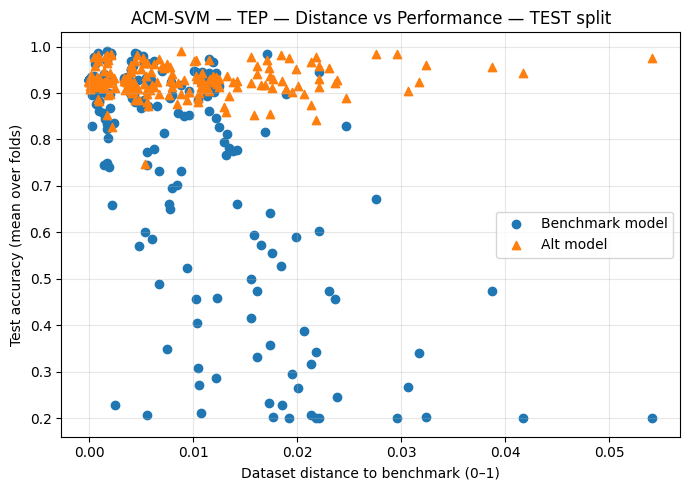

In [45]:
datasets = ["tep"]
splits = ["test"]

for dataset in datasets:
    for _, _, model_name, _ in models_to_evaluate:
        csv_path = f"results/{dataset}_results_{model_name.lower().replace('-', '_')}.csv"
        if not os.path.isfile(csv_path):
            print(f"[WARN] Results CSV not found: {csv_path}. Skipping.")
            continue
        print(f"\n[INFO] Loading and plotting: {csv_path}")
        df = pd.read_csv(csv_path)
        for split in splits:
            try:
                plot_results(
                    df,
                    split=split,
                    title=f"{model_name} — {dataset.upper()} — Distance vs Performance",
                    show=True
                )
            except Exception as e:
                print(f"[ERROR] Failed to plot {csv_path} (split={split}): {e}")


=== Evaluating selection strategy for model: WDI-1NN ===
Baseline (benchmark __benchmark__ VAL): 0.7063
Versions included: 200
Selected benchmark for 111 versions; alt for 89 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 79
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 32

Average TEST accuracy (selection strategy): 0.6914
Average TEST accuracy (benchmark-only):     0.6220
Average TEST accuracy (alt-only):           0.6745


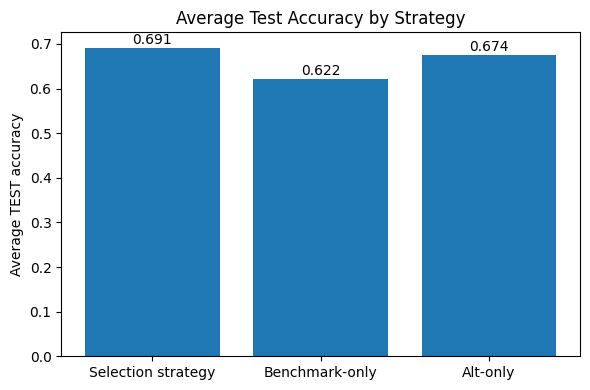


=== Evaluating selection strategy for model: CASIM ===
Baseline (benchmark __benchmark__ VAL): 0.8075
Versions included: 200
Selected benchmark for 30 versions; alt for 170 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 30
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 0

Average TEST accuracy (selection strategy): 0.8937
Average TEST accuracy (benchmark-only):     0.6817
Average TEST accuracy (alt-only):           0.9085


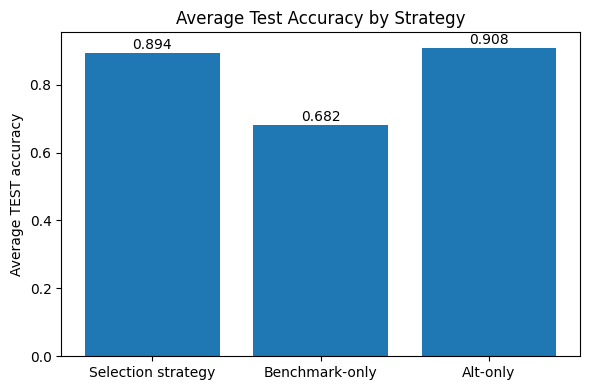


=== Evaluating selection strategy for model: EAC-1NN ===
Baseline (benchmark __benchmark__ VAL): 0.8512
Versions included: 200
Selected benchmark for 42 versions; alt for 158 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 36
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 6

Average TEST accuracy (selection strategy): 0.8539
Average TEST accuracy (benchmark-only):     0.6194
Average TEST accuracy (alt-only):           0.8573


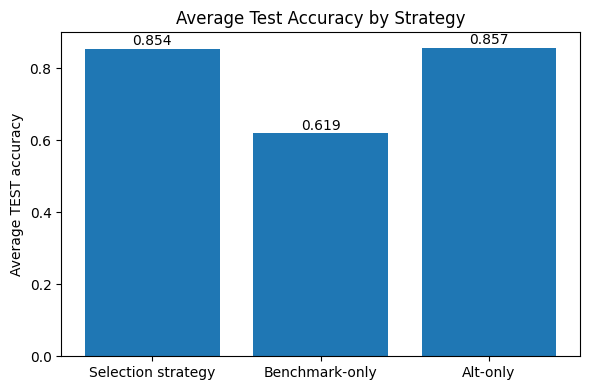


=== Evaluating selection strategy for model: MBW-LR ===
Baseline (benchmark __benchmark__ VAL): 0.9150
Versions included: 200
Selected benchmark for 54 versions; alt for 146 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 54
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 0

Average TEST accuracy (selection strategy): 0.8905
Average TEST accuracy (benchmark-only):     0.8069
Average TEST accuracy (alt-only):           0.8942


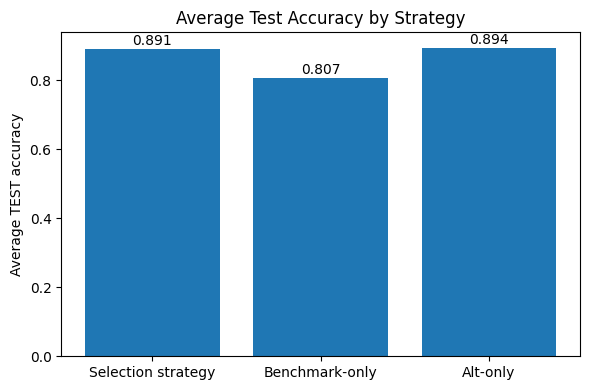


=== Evaluating selection strategy for model: ACM-SVM ===
Baseline (benchmark __benchmark__ VAL): 0.9262
Versions included: 200
Selected benchmark for 76 versions; alt for 124 versions.
Trigger counts:
  • Benchmark ≥ baseline on new VAL (picked benchmark): 64
  • Benchmark < baseline on new VAL but alt VAL worse (still picked benchmark): 12

Average TEST accuracy (selection strategy): 0.9275
Average TEST accuracy (benchmark-only):     0.7635
Average TEST accuracy (alt-only):           0.9258


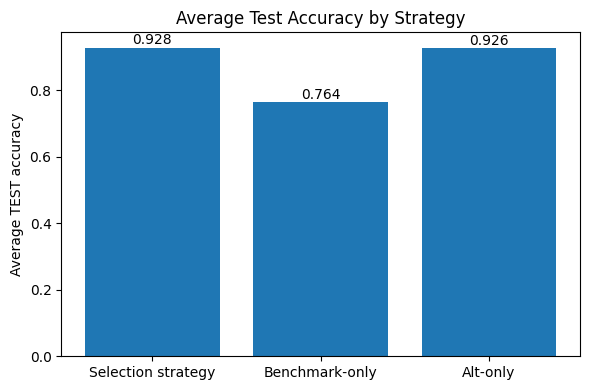

In [46]:
for model, model_params, model_name, use_argmin in models_to_evaluate:
    print(f"\n=== Evaluating selection strategy for model: {model_name} ===")
    csv_path = f"results/tep_results_{model_name.lower().replace('-', '_')}.csv"
    if not os.path.isfile(csv_path):
        print(f"[WARN] Results CSV not found: {csv_path}. Skipping.")
        continue
    summary, per_version = evaluate_selection_strategy(csv_path, plot=True)